### SET_UP


In [1]:
import torch
import os
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
import random
from utils import save_check
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import collections
from tqdm import tqdm
from copy import deepcopy
import time
from sklearn.metrics import roc_curve
import numpy as np
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = []

        # assuming the directory structure is as follows:
        # root_dir
        # ├── 0 (no PE)
        # └── 1 (yes)
        for label, class_name in enumerate(['0', '1']):
            class_dir = os.path.join(root_dir, class_name)
            file_list = os.listdir(class_dir)
            final_file_list = random.sample(file_list, len(file_list))
            for filename in final_file_list:
                if filename.endswith('.pt'):
                    self.samples.append((os.path.join(class_dir, filename), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        sample_path, label = self.samples[index]
        image = torch.load(sample_path)
        image = image.unsqueeze_(0)
        image = torch.repeat_interleave(image, 3, dim = 0)
        
        
        return image, label

In [3]:
resnet_model = models.resnet50(pretrained = True)
resnet_model = resnet_model.cuda()

checkpoint = torch.load('runs/FIFTH/checkpoint_0075.pth.tar')
possible = collections.OrderedDict()
state_dict = collections.OrderedDict()

del checkpoint['state_dict']['resnet_model.fc.2.bias']
del checkpoint['state_dict']['resnet_model.fc.2.weight']

possible['fc.bias'] = checkpoint['state_dict']['resnet_model.fc.0.bias'][0:1000] # (2)
possible['fc.weight'] = checkpoint['state_dict']['resnet_model.fc.0.weight'][0:1000]
del checkpoint['state_dict']['resnet_model.fc.0.bias']
del checkpoint['state_dict']['resnet_model.fc.0.weight']
for k in checkpoint['state_dict'].keys():
    value = checkpoint['state_dict'][k]
    k = k.replace('resnet_model.', '')
    possible[k] = value

resnet_model.load_state_dict(possible)


/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [4]:
train_dataset = CustomDataset('testData/train_set')
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CustomDataset('testData/val_set')
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = True)

test_dataset = CustomDataset('testData/test_set')
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of test examples:", len(test_dataset))

Number of training examples: 7562
Number of validation examples: 4511
Number of test examples: 6003


In [5]:
NUM_WORKERS = os.cpu_count()
@torch.no_grad()

def prepare_data_features(dataset):
    # Prepare model
    network = deepcopy(resnet_model)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=True, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return TensorDataset(feats, labels)

In [6]:
train_feats = prepare_data_features(train_dataset)



100%|██████████| 119/119 [01:13<00:00,  1.62it/s]


In [7]:
test_feats = prepare_data_features(test_dataset)

100%|██████████| 94/94 [00:59<00:00,  1.59it/s]


In [8]:
class LogisticRegression(pl.LightningModule):

    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=250):
        super(LogisticRegression, self).__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        self.model = nn.Sequential(
            nn.Linear(feature_dim, num_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs*0.6),
                                                                  int(self.hparams.max_epochs*0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)
        preds = preds.float()
        #preds = preds.squeeze(1)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

In [9]:
from sklearn.metrics import roc_curve
class MultiLayerPerceptron(pl.LightningModule):
    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs = 250):
        super(MultiLayerPerceptron, self).__init__()
        self.save_hyperparameters()
        
        # Map representations h to class predictions
        self.model = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)
        
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs*0.6),
                                                                  int(self.hparams.max_epochs*0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)
        preds = preds.float()
        preds = preds.round()


        #preds = preds.squeeze(1)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss
    
    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')



In [10]:
def train_logreg(batch_size, train_feats_data, test_feats_data, max_epochs=250, **kwargs):
    trainer = pl.Trainer(default_root_dir='runs/LogisticRegression/',
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=True,
                         check_val_every_n_epoch=10)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    pl.seed_everything(42)  # To be reproducable
    model = LogisticRegression(**kwargs)
    trainer.fit(model, train_loader, test_loader)
    model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    
    preds = []
    labels = []
    train_result = trainer.test(model, train_loader, verbose=False)
    t0 = time.time()
    test_result = trainer.test(model, test_loader, verbose=False)
    t1 = time.time()
    for data, lbls in test_loader:
        predictions = model(data)
        preds.append(predictions[:,1].detach().numpy())
        labels.append(lbls.detach().numpy())
    preds = np.concatenate(preds)
    labels = np.concatenate(labels)
    curve = roc_curve(labels, preds)

    
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"], "time": f"{t1 - t0}", "curve" : curve}

    return model, result

In [12]:
from sklearn.metrics import *

def train_mlp(batch_size, train_feats_data, test_feats_data, max_epochs=250, **kwargs):
    trainer = pl.Trainer(default_root_dir='runs/MLP/',
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=True,
                         check_val_every_n_epoch=10)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    pl.seed_everything(42)  # To be reproducable
    model = MultiLayerPerceptron(**kwargs)
    trainer.fit(model, train_loader, test_loader)
    model = MultiLayerPerceptron.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    preds = []
    labels = []
    train_result = trainer.test(model, train_loader, verbose=False)
    t0 = time.time()
    test_result = trainer.test(model, test_loader, verbose=False)
    t1 = time.time()
    for data, lbls in test_loader:
        predictions = model(data)
        predictions = predictions.round()
        preds.append(predictions[:,1].detach().numpy())
        labels.append(lbls.detach().numpy())
    preds = np.concatenate(preds)
    labels = np.concatenate(labels)
    curve = roc_curve(labels, preds)
    score = roc_auc_score(labels, preds)
    #precision = precision_score(labels, preds)
    #fOne = f1_score(labels, preds)


    
    result = {"train": train_result[0]['test_acc'], "test": test_result[0]['test_acc'], "time": f"{t1 - t0}", "curve" : curve, "score" : score}

    return model, result

In [127]:
_, log_reg_results = train_logreg(
    batch_size=8192,
    train_feats_data=train_feats,
    test_feats_data=test_feats,
    num_classes = 2, 
    feature_dim=train_feats.tensors[0].shape[1],
    lr=1e-1,
    weight_decay=1e-3
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 4.1 K 
-------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(lo

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

In [15]:
_, mlp_results = train_mlp(
    batch_size=8,
    train_feats_data=train_feats,
    test_feats_data=test_feats,
    num_classes = 2, 
    feature_dim=train_feats.tensors[0].shape[1],
    lr=1e-1,
    weight_decay=1e-3
)

'''_, small_set_results = train_mlp(
    batch_size=256,
    train_feats_data=train_feats,
    test_feats_data=test_feats,
    num_classes = 2, 
    feature_dim=train_feats.tensors[0].shape[1],
    lr=2e-1,
    weight_decay=1e-2
)'''

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 1.3 M 
-------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.251     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [14]:
#DEMO
mlp_results

{'train': 0.5923036336898804,
 'test': 0.5458937287330627,
 'time': '0.08075737953186035',
 'curve': (array([0.00000000e+00, 3.05157156e-04, 1.00000000e+00]),
  array([0.00000000e+00, 7.33675715e-04, 1.00000000e+00]),
  array([2., 1., 0.], dtype=float32)),
 'score': 0.5002142592796993}

In [13]:
# logistic regression after one more training session
small_set_results

{'train': 0.9969584941864014, 'test': 0.6293519735336304}

In [114]:
# logreg with bs 128, lr = 1e-1, wd = 1e-3, epochs = 250
logreg_128_250 = log_reg_results
logreg_128_250

{'train': 1.0,
 'test': 0.6138597130775452,
 'time': '0.17182230949401855',
 'curve': (array([0.        , 0.        , 0.        , ..., 0.99725359, 0.99725359,
         1.        ]),
  array([0.        , 0.00220103, 0.00513573, ..., 0.99963316, 1.        ,
         1.        ]),
  array([2.0000000e+00, 1.0000000e+00, 9.9999988e-01, ..., 2.0320761e-09,
         1.7293076e-09, 1.9969869e-14], dtype=float32))}

In [117]:
# logreg with bs 256, lr = 1e-1, wd = 1e-3, epochs = 250
logreg_256_250 = log_reg_results
logreg_256_250

{'train': 1.0,
 'test': 0.617024838924408,
 'time': '0.13608050346374512',
 'curve': (array([0.        , 0.        , 0.        , ..., 0.99755874, 0.99755874,
         1.        ]),
  array([0.00000000e+00, 7.33675715e-04, 2.20102715e-03, ...,
         9.99633162e-01, 1.00000000e+00, 1.00000000e+00]),
  array([2.0000000e+00, 1.0000000e+00, 9.9999952e-01, ..., 1.7787659e-08,
         1.5664714e-08, 4.8659086e-13], dtype=float32))}

In [120]:
# logreg with bs 512, lr = 1e-1, wd = 1e-3, epochs = 250
logreg_512_250 = log_reg_results
logreg_512_250

{'train': 0.9998677372932434,
 'test': 0.6230218410491943,
 'time': '0.11008071899414062',
 'curve': (array([0.       , 0.       , 0.       , ..., 0.9978639, 0.9978639,
         1.       ]),
  array([0.00000000e+00, 3.66837858e-04, 8.07043287e-03, ...,
         9.99633162e-01, 1.00000000e+00, 1.00000000e+00]),
  array([1.99999881e+00, 9.99998808e-01, 9.99972105e-01, ...,
         1.67560216e-07, 1.01073276e-07, 3.03872344e-10], dtype=float32))}

In [122]:
# logreg with bs 1024, lr = 1e-1, wd = 1e-3, epochs = 250
logreg_1024_250 = log_reg_results
logreg_1024_250

{'train': 0.995900571346283,
 'test': 0.6275195479393005,
 'time': '0.09761166572570801',
 'curve': (array([0.        , 0.        , 0.        , ..., 0.99755874, 0.99755874,
         1.        ]),
  array([0.00000000e+00, 3.66837858e-04, 2.75128393e-02, ...,
         9.99633162e-01, 1.00000000e+00, 1.00000000e+00]),
  array([1.9999965e+00, 9.9999654e-01, 9.9979311e-01, ..., 1.1253843e-05,
         6.5552240e-06, 3.4898495e-08], dtype=float32))}

In [124]:
# logreg with bs 2048, lr = 1e-1, wd = 1e-3, epochs = 250
logreg_2048_250 = log_reg_results
logreg_2048_250

{'train': 0.9485585689544678,
 'test': 0.6366816759109497,
 'time': '0.06997299194335938',
 'curve': (array([0.        , 0.        , 0.        , ..., 0.99450717, 0.99450717,
         1.        ]),
  array([0.00000000e+00, 3.66837858e-04, 1.94424065e-02, ...,
         9.99633162e-01, 1.00000000e+00, 1.00000000e+00]),
  array([1.9999678e+00, 9.9996781e-01, 9.9953365e-01, ..., 5.3800305e-04,
         5.2936113e-04, 2.2811632e-06], dtype=float32))}

In [126]:
# logreg with bs 4096, lr = 1e-1, wd = 1e-3, epochs = 250
logreg_4096_250 = log_reg_results
logreg_4096_250

{'train': 0.9736841917037964,
 'test': 0.6376811861991882,
 'time': '0.08726835250854492',
 'curve': (array([0.        , 0.        , 0.        , ..., 0.99481233, 0.99481233,
         1.        ]),
  array([0.00000000e+00, 3.66837858e-04, 2.38444607e-02, ...,
         9.99633162e-01, 1.00000000e+00, 1.00000000e+00]),
  array([1.9999961e+00, 9.9999607e-01, 9.9983954e-01, ..., 1.9726834e-04,
         1.9121659e-04, 3.7242447e-07], dtype=float32))}

In [128]:
# logreg with bs 8192, lr = 1e-1, wd = 1e-3, epochs = 250
logreg_8192_250 = log_reg_results
logreg_8192_250

{'train': 0.9726263284683228,
 'test': 0.640679657459259,
 'time': '0.08999514579772949',
 'curve': (array([0.        , 0.        , 0.        , ..., 0.99450717, 0.99450717,
         1.        ]),
  array([0.00000000e+00, 3.66837858e-04, 7.33675715e-03, ...,
         9.99266324e-01, 1.00000000e+00, 1.00000000e+00]),
  array([1.9999958e+00, 9.9999583e-01, 9.9995077e-01, ..., 3.2084901e-04,
         2.8796907e-04, 5.7197377e-07], dtype=float32))}

In [53]:
# mlp with bs 4, lr = 1e-1, wd = 1e-3, epochs = 600
small_set_results

{'train': 0.995503842830658,
 'test': 0.6871564388275146,
 'time': '3.1920270919799805'}

In [51]:
# mlp with bs 8, lr = 1e-1, wd = 1e-3, epochs = 600
small_set_results

{'train': 0.9960327744483948,
 'test': 0.6948192715644836,
 'time': '1.6959030628204346'}

In [194]:

mlp_8_tryAgain = mlp_results
#mlp_8_250['test'] = 0.6948192715644836
mlp_8_tryAgain

{'train': 0.9853213429450989,
 'test': 0.6951524019241333,
 'time': '1.699692964553833',
 'curve': (array([0.00000000e+00, 3.05157156e-04, 9.15471468e-04, ...,
         9.71620384e-01, 9.71620384e-01, 1.00000000e+00]),
  array([0.        , 0.        , 0.        , ..., 0.99963316, 1.        ,
         1.        ]),
  array([1.9999962e+00, 9.9999619e-01, 9.9999559e-01, ..., 1.0856575e-04,
         1.0774635e-04, 1.4443181e-08], dtype=float32))}

In [22]:
mlp_8_tryOneMoreTime = mlp_results
mlp_8_tryOneMoreTime

{'train': 0.9949748516082764,
 'test': 0.6948192715644836,
 'time': '1.6425516605377197',
 'curve': (array([0.00000000e+00, 0.00000000e+00, 3.05157156e-04, ...,
         9.81385413e-01, 9.81385413e-01, 1.00000000e+00]),
  array([0.00000000e+00, 3.66837858e-04, 3.66837858e-04, ...,
         9.99633162e-01, 1.00000000e+00, 1.00000000e+00]),
  array([1.99999750e+00, 9.99997497e-01, 9.99996424e-01, ...,
         1.17522606e-04, 1.15104354e-04, 5.98808541e-08], dtype=float32)),
 'score': 0.6770668240438764}

In [164]:
mlp_8_250 = mlp_results
#mlp_8_250['test'] = 0.6948192715644836
mlp_8_250

{'train': 0.9997355341911316,
 'test': 0.6948192715644836,
 'time': '1.703371286392212',
 'curve': (array([0.00000000e+00, 3.05157156e-04, 8.54440037e-03, ...,
         9.65212084e-01, 9.65212084e-01, 1.00000000e+00]),
  array([0.        , 0.        , 0.        , ..., 0.99963316, 1.        ,
         1.        ]),
  array([1.9999971e+00, 9.9999714e-01, 9.9997377e-01, ..., 1.6496946e-04,
         1.6351583e-04, 3.2015802e-08], dtype=float32))}

In [44]:
# mlp with bs 32, lr = 1e-1, wd = 1e-3, epochs = 600
small_set_results

{'train': 1.0, 'test': 0.6721639037132263}

In [192]:
mlp_32_250 = mlp_results
mlp_32_250

{'train': 0.99920654296875,
 'test': 0.6691654324531555,
 'time': '0.5928547382354736',
 'curve': (array([0.00000000e+00, 3.05157156e-04, 2.13610009e-03, ...,
         9.70094599e-01, 9.70094599e-01, 1.00000000e+00]),
  array([0.        , 0.        , 0.        , ..., 0.99963316, 1.        ,
         1.        ]),
  array([1.9999859e+00, 9.9998593e-01, 9.9997795e-01, ..., 2.3036172e-04,
         2.2960454e-04, 1.9181923e-06], dtype=float32))}

In [41]:
# mlp with bs 64, lr = 1e-1, wd = 1e-3, epochs = 600
small_set_results

{'train': 1.0, 'test': 0.6611694097518921}

In [190]:
# mlp with bs 64, lr = 1e-1, wd = 1e-3, epochs = 600
mlp_64_250 = mlp_results
mlp_64_250

{'train': 0.9997355341911316,
 'test': 0.6686656475067139,
 'time': '0.3261103630065918',
 'curve': (array([0.00000000e+00, 3.05157156e-04, 3.05157156e-04, ...,
         9.65212084e-01, 9.65212084e-01, 1.00000000e+00]),
  array([0.00000000e+00, 0.00000000e+00, 3.66837858e-04, ...,
         9.99633162e-01, 1.00000000e+00, 1.00000000e+00]),
  array([1.99993885e+00, 9.99938846e-01, 9.99930739e-01, ...,
         1.18640135e-04, 1.14069073e-04, 8.29869293e-08], dtype=float32))}

In [31]:
# mlp with bs 128, lr = 1e-1, wd = 1e-3, epochs = 600
small_set_results

{'train': 0.9944459199905396, 'test': 0.6669998168945312}

In [188]:
mlp_128_250 = mlp_results
mlp_128_250

{'train': 0.9878339171409607,
 'test': 0.6578377485275269,
 'time': '0.17455768585205078',
 'curve': (array([0.00000000e+00, 3.05157156e-04, 6.10314312e-04, ...,
         9.66737870e-01, 9.66737870e-01, 1.00000000e+00]),
  array([0.        , 0.        , 0.        , ..., 0.99963316, 1.        ,
         1.        ]),
  array([1.9998797e+00, 9.9987972e-01, 9.9986351e-01, ..., 2.2195665e-05,
         2.1946498e-05, 5.3193549e-08], dtype=float32))}

In [183]:
# mlp with bs 256, lr = 1e-1, wd = 1e-3, epochs = 600
mlp_256_250 = mlp_results
mlp_256_250

{'train': 0.9869081974029541,
 'test': 0.6590038537979126,
 'time': '0.15485930442810059',
 'curve': (array([0.00000000e+00, 3.05157156e-04, 3.05157156e-04, ...,
         9.71620384e-01, 9.71620384e-01, 1.00000000e+00]),
  array([0.        , 0.        , 0.00220103, ..., 0.99963316, 1.        ,
         1.        ]),
  array([1.9998000e+00, 9.9979991e-01, 9.9966574e-01, ..., 5.0175724e-05,
         4.5115099e-05, 1.5044800e-07], dtype=float32))}

In [181]:
mlp_512_250 = mlp_results
mlp_512_250

{'train': 0.9904786944389343,
 'test': 0.6575045585632324,
 'time': '0.12472176551818848',
 'curve': (array([0.00000000e+00, 3.05157156e-04, 9.15471468e-04, ...,
         9.75892585e-01, 9.75892585e-01, 1.00000000e+00]),
  array([0.        , 0.        , 0.        , ..., 0.99963316, 1.        ,
         1.        ]),
  array([1.9998678e+00, 9.9986780e-01, 9.9975199e-01, ..., 6.1289858e-05,
         6.0738163e-05, 9.8037781e-08], dtype=float32))}

In [179]:
# mlp with bs 1024, lr = 1e-1, wd = 1e-3, epochs = 600
mlp_1024_250 = mlp_results
mlp_1024_250

{'train': 0.9362602233886719,
 'test': 0.6415125727653503,
 'time': '0.08116865158081055',
 'curve': (array([0.00000000e+00, 0.00000000e+00, 3.05157156e-04, ...,
         9.86878242e-01, 9.86878242e-01, 1.00000000e+00]),
  array([0.00000000e+00, 3.66837858e-04, 3.66837858e-04, ...,
         9.99633162e-01, 1.00000000e+00, 1.00000000e+00]),
  array([1.9977725e+00, 9.9777251e-01, 9.9691260e-01, ..., 7.9589942e-04,
         7.8851724e-04, 1.4663862e-05], dtype=float32))}

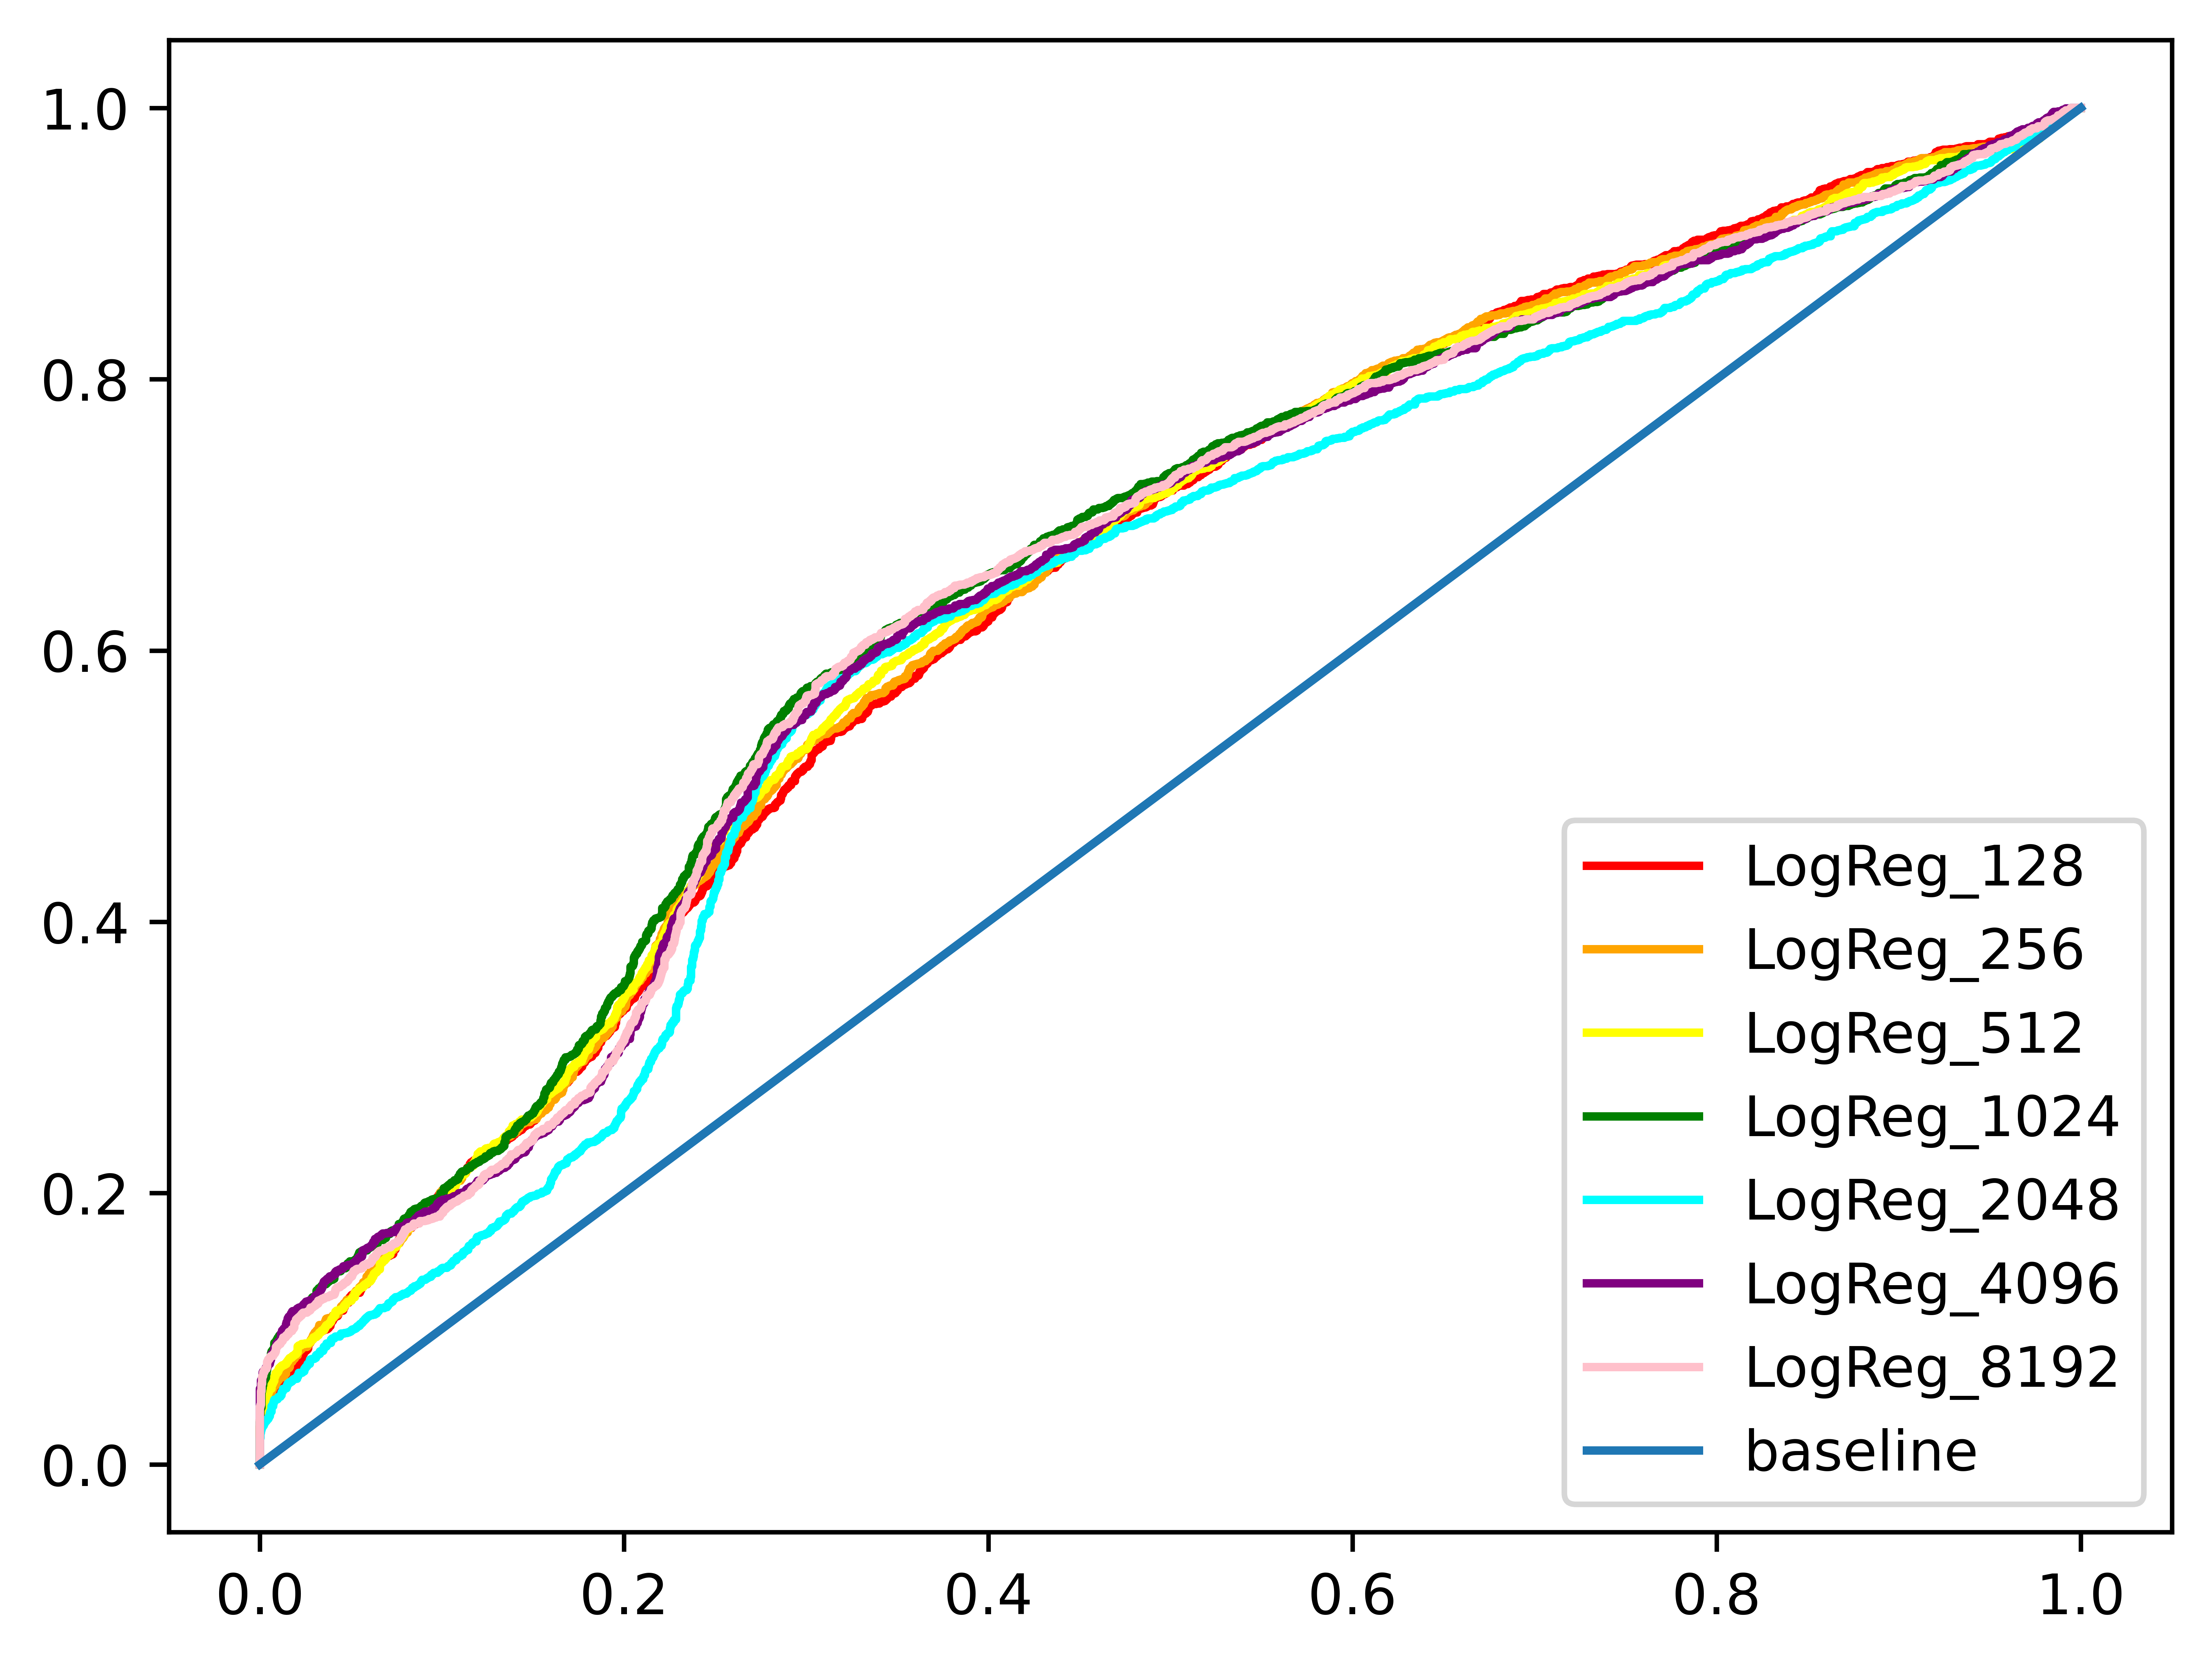

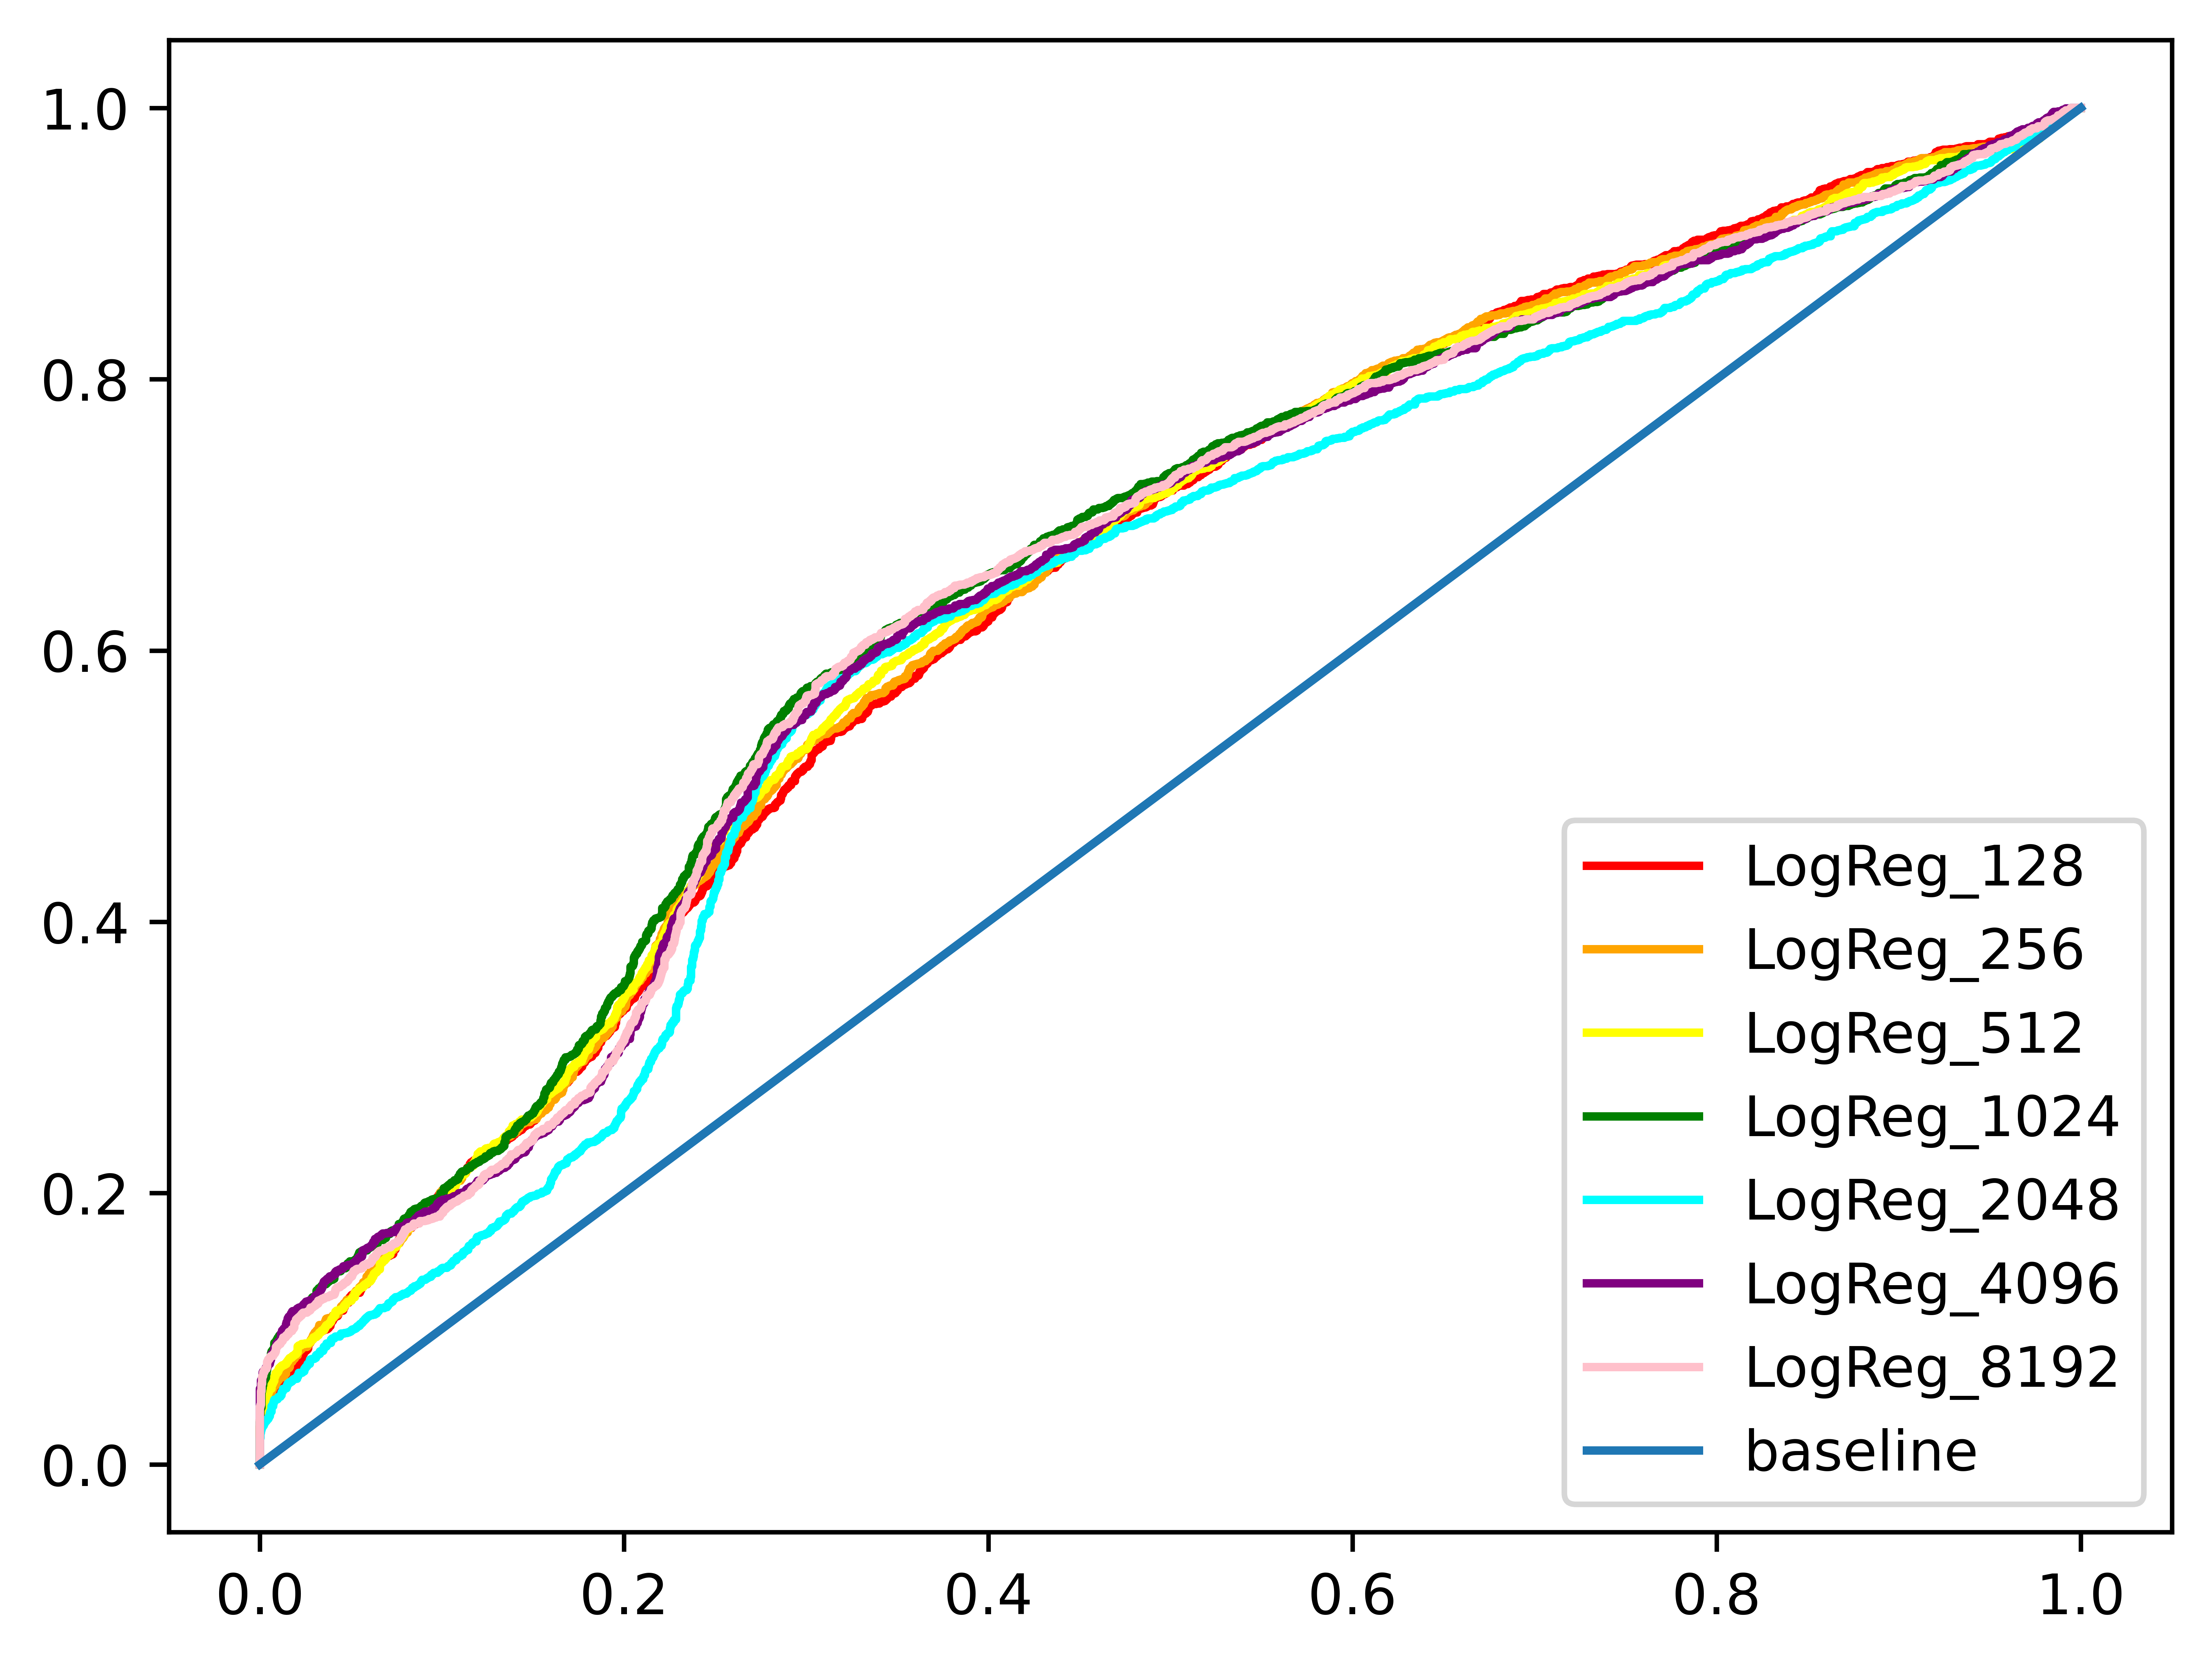

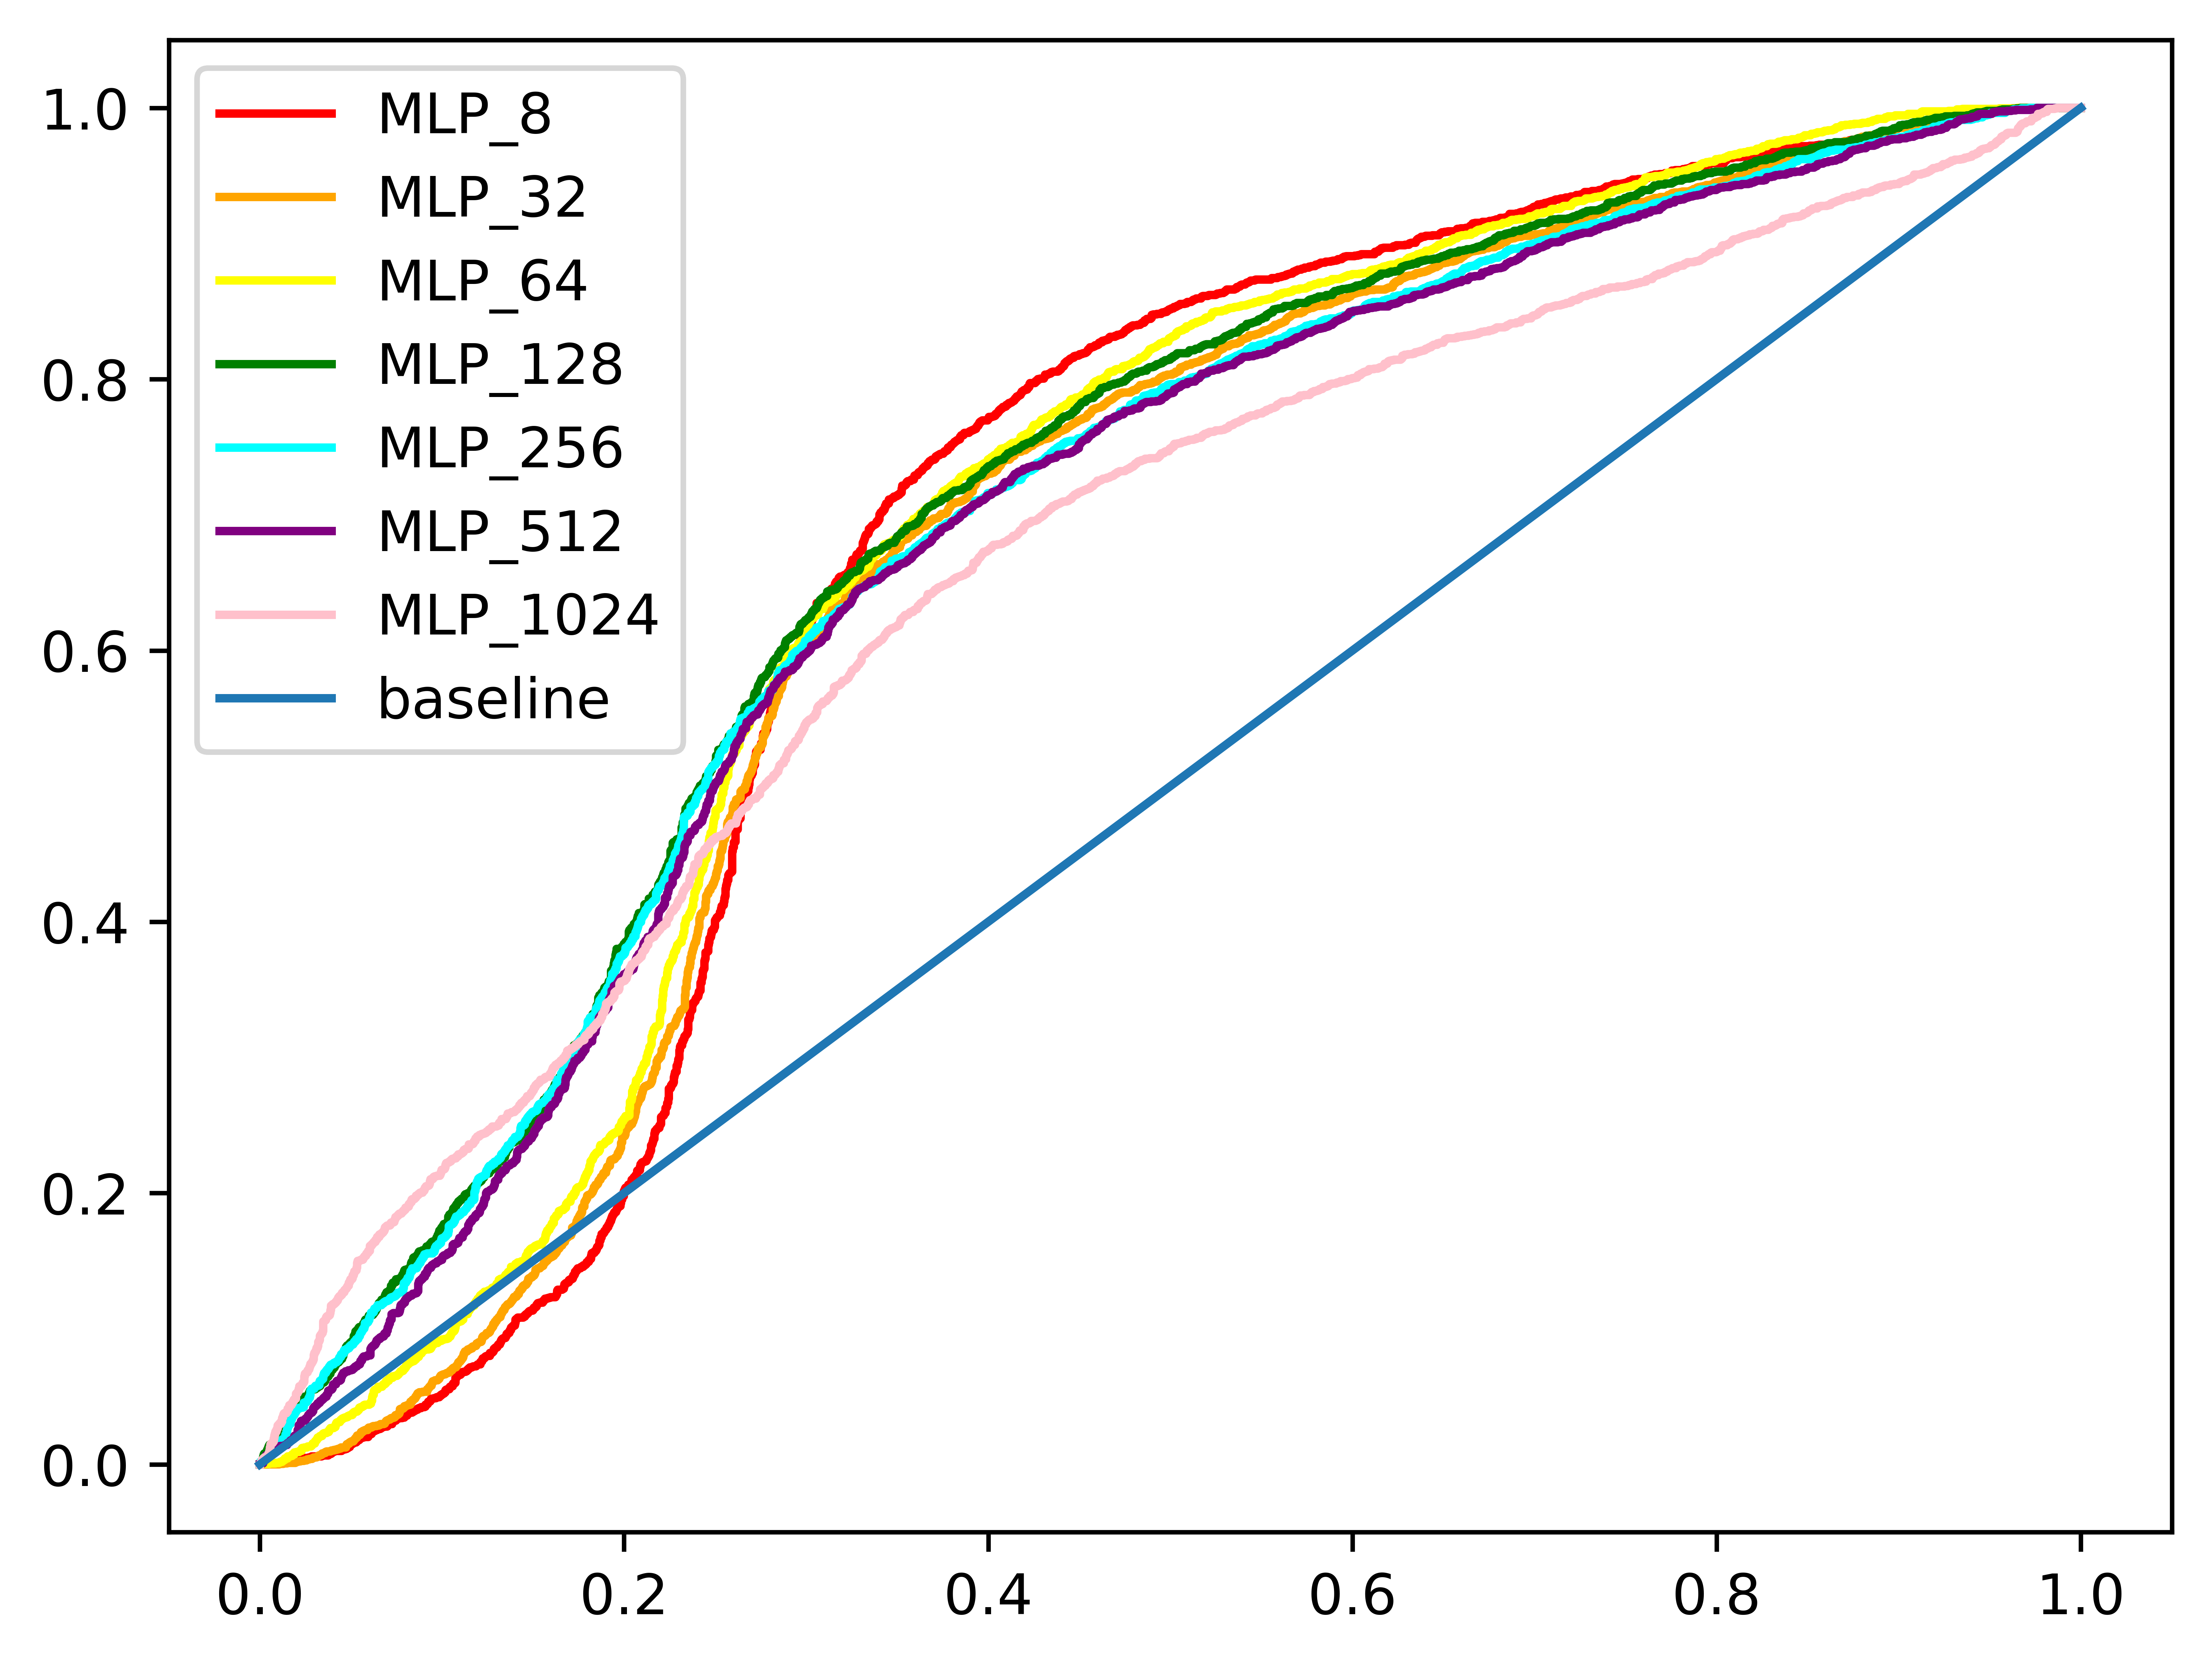

In [195]:
# test stuff for logistic regression
# test stuff for logistic regression
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
plt.figure(dpi = 1200)
fpr, tpr, thresholds = logreg_128_250['curve']
plt.plot(fpr, tpr, color = "red", label = "LogReg_128")
fpr, tpr, thresholds = logreg_256_250['curve']
plt.plot(fpr, tpr, color = "orange", label = "LogReg_256")
fpr, tpr, thresholds = logreg_512_250['curve']
plt.plot(fpr, tpr, color = "yellow", label = "LogReg_512")
fpr, tpr, thresholds = logreg_1024_250['curve']
plt.plot(fpr, tpr, color = "green", label = "LogReg_1024")
fpr, tpr, thresholds = logreg_2048_250['curve']
plt.plot(fpr, tpr, color = "cyan", label = "LogReg_2048")
fpr, tpr, thresholds = logreg_4096_250['curve']
plt.plot(fpr, tpr, color = "purple", label = "LogReg_4096")
fpr, tpr, thresholds = logreg_8192_250['curve']
plt.plot(fpr, tpr, color = "pink", label = "LogReg_8192")
plt.plot([0, 1], [0, 1], label = "baseline")
plt.legend()
from matplotlib import pyplot as plt
plt.figure(dpi = 1200)
fpr, tpr, thresholds = mlp_8_tryAgain['curve']
plt.plot(fpr, tpr, color = "red", label = "MLP_8")
fpr, tpr, thresholds = mlp_32_250['curve']
plt.plot(fpr, tpr, color = "orange", label = "MLP_32")
fpr, tpr, thresholds = mlp_64_250['curve']
plt.plot(fpr, tpr, color = "yellow", label = "MLP_64")
fpr, tpr, thresholds = mlp_128_250['curve']
plt.plot(fpr, tpr, color = "green", label = "MLP_128")
fpr, tpr, thresholds = mlp_256_250['curve']
plt.plot(fpr, tpr, color = "cyan", label = "MLP_256")
fpr, tpr, thresholds = mlp_512_250['curve']
plt.plot(fpr, tpr, color = "purple", label = "MLP_512")
fpr, tpr, thresholds = mlp_1024_250['curve']
plt.plot(fpr, tpr, color = "pink", label = "MLP_1024")
plt.plot([0, 1], [0, 1], label = "baseline")
plt.legend()

In [1]:
# test stuff for logistic regression
# test stuff for logistic regression
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
plt.figure(dpi = 1200)
time = logreg_128_250['time']
plt.plot(time, color = "red", label = "LogReg_128")
fpr, tpr, thresholds = logreg_256_250['time']
plt.plot(fpr, tpr, color = "orange", label = "LogReg_256")
fpr, tpr, thresholds = logreg_512_250['time']
plt.plot(fpr, tpr, color = "yellow", label = "LogReg_512")
fpr, tpr, thresholds = logreg_1024_250['time']
plt.plot(fpr, tpr, color = "green", label = "LogReg_1024")
fpr, tpr, thresholds = logreg_2048_250['time']
plt.plot(fpr, tpr, color = "cyan", label = "LogReg_2048")
fpr, tpr, thresholds = logreg_4096_250['time']
plt.plot(fpr, tpr, color = "purple", label = "LogReg_4096")
fpr, tpr, thresholds = logreg_8192_250['time']
plt.plot(fpr, tpr, color = "pink", label = "LogReg_8192")
#plt.plot([0, 1], [0, 1], label = "baseline")
plt.legend()
from matplotlib import pyplot as plt
plt.figure(dpi = 1200)
fpr, tpr, thresholds = mlp_8_tryAgain['curve']
plt.plot(fpr, tpr, color = "red", label = "MLP_8")
fpr, tpr, thresholds = mlp_32_250['curve']
plt.plot(fpr, tpr, color = "orange", label = "MLP_32")
fpr, tpr, thresholds = mlp_64_250['curve']
plt.plot(fpr, tpr, color = "yellow", label = "MLP_64")
fpr, tpr, thresholds = mlp_128_250['curve']
plt.plot(fpr, tpr, color = "green", label = "MLP_128")
fpr, tpr, thresholds = mlp_256_250['curve']
plt.plot(fpr, tpr, color = "cyan", label = "MLP_256")
fpr, tpr, thresholds = mlp_512_250['curve']
plt.plot(fpr, tpr, color = "purple", label = "MLP_512")
fpr, tpr, thresholds = mlp_1024_250['curve']
plt.plot(fpr, tpr, color = "pink", label = "MLP_1024")
plt.plot([0, 1], [0, 1], label = "baseline")
plt.legend()

NameError: name 'logreg_128_250' is not defined

<Figure size 7680x5760 with 0 Axes>

In [196]:
fig = plt.figure(dpi = 1200)
ax = fig.add_axes([0, 0,1,1])
batch_sizes = ['8', '32', '64', '128', '256', '512', '1024']
font = {'family':'serif','color':'blue','size': 20}
accuracies = [69.51524019241333, 67.21639037132263, 66.11694097518921, 66.69998168945312, 66.55005812644958, 65.63385128974915, 63.45160603523254]
ax.bar(batch_sizes, accuracies, color = ["#92E8E5", "#93D4F6", "#A1BDFF", "#EDC2F7", "#FCDCC8", "#F7EFCF", "pink"])
plt.xlabel("Batch Size", fontdict = font)
plt.ylabel("Accuracy", fontdict = font)
plt.show()
#plt.savefig("batch_sizes_to_accuracy.png", dpi = 1200)

In [209]:
fig = plt.figure(dpi = 2000)
ax = fig.add_axes([0, 0,1,1])
batch_sizes = ['Baseline', 'State of the Art', b'OURS']
font = {'family':'serif','color':'blue','size': 16}
accuracies = [35.22, 68.900, 69.51524019241333]
ax.bar(batch_sizes, accuracies, color = ["#92E8E5", "#93D4F6", "#A1BDFF"])
plt.xlabel("Model", fontdict = font)
plt.ylabel("Accuracy", fontdict = font)
plt.show()

In [ ]:
fig = plt.figure(dpi = 2000)
ax = fig.add_axes([0, 0,1,1])
batch_sizes = ['8', '32', '64', '128', '256', '512', '1024']
font = {'family':'serif','color':'blue','size': 16}
accuracies = [1.699692964553833, , 69.51524019241333]
ax.bar(batch_sizes, accuracies, color = ["#92E8E5", "#93D4F6", "#A1BDFF"])
plt.xlabel("Model", fontdict = font)
plt.ylabel("Accuracy", fontdict = font)
plt.show()

### LESS RECENT ONES

In [15]:
# mlp  after one more training session
small_set_results

{'train': 0.9041258692741394, 'test': 0.6218557357788086}

In [17]:
# mlp, lower learning rate, one more training session
small_set_results

{'train': 0.5923036336898804, 'test': 0.5458937287330627}

In [19]:
# mlp, lower weight decay, one more training session
small_set_results

{'train': 0.910341203212738, 'test': 0.6228552460670471}

In [21]:
# mlp, higher batch size, lower weight decay, same learning rate, one more training session
small_set_results

{'train': 0.6544564962387085, 'test': 0.549225389957428}

In [119]:
#logistic regression
small_set_results

{'train': 0.9997355341911316, 'test': 0.5720472931861877}

In [127]:
# no sigmoid
small_set_results

{'train': 0.978312611579895, 'test': 0.6495085954666138}

In [129]:
# no sigmoid + MLP + lower learning rate
small_set_results

{'train': 0.5923036336898804, 'test': 0.5458937287330627}

In [133]:
# sigmoid + MLP + lower learning rate
small_set_results

{'train': 0.5923036336898804, 'test': 0.5458937287330627}

In [146]:
# sigmoid + MLP + lower weight decay + LR + higher batch size
small_set_results

{'train': 0.5923036336898804, 'test': 0.5458937287330627}

: 

In [44]:
# weight decay: 1e-2
small_set_results

{'train': 0.9129859805107117, 'test': 0.6255205869674683}

In [46]:
# weight decay = 1e-5
small_set_results

{'train': 0.8591642379760742, 'test': 0.5870398283004761}

In [48]:
# mlp + learning rate = 1e-1, weight_decay = 1e-3, epochs = 250
small_set_results

{'train': 0.9940491914749146, 'test': 0.6651673913002014}

In [50]:
# mlp + 256, learning rate = 1e-1, weight_decay = 1e-3, epochs = 500
small_set_results

{'train': 0.9935202598571777, 'test': 0.6655005812644958}

In [52]:
# mlp + 512, learning_rate = 1e-1
small_set_results

{'train': 0.9902142286300659, 'test': 0.6570048332214355}

In [55]:
# mlp + 256, learning_rate = 1e-1, epochs of 500
small_set_results

{'train': 0.9924623370170593, 'test': 0.656005322933197}

In [57]:
# mlp + 256, learning_rate = 1e-1, weight_decay = 1e-2, epochs of 500
small_set_results

{'train': 0.975006639957428, 'test': 0.6533399820327759}

In [59]:
#mlp + 256, learning_rate = 2e-1, weight_decay = 1e-2, epochs of 500
small_set_results

{'train': 0.975006639957428, 'test': 0.6623355150222778}

In [61]:
# mlp + 256, learning_rate = 3e-2, weight_decay = 1e-2, epochs of 500
small_set_results

{'train': 0.9226394891738892, 'test': 0.6331834197044373}

In [64]:
# mlp + 256, learning_rate = 2e-2, weight_decay = 1e-2, epochs of 500
small_set_results

{'train': 0.855593740940094, 'test': 0.5843744874000549}

In [66]:
# mlp + 256, learning_rate = 2e-1, weight_decay = 1e-2, epochs of 500
small_set_results

{'train': 0.9768579602241516, 'test': 0.6616691946983337}

### TWO MORE TRAINING SESSIONS

In [75]:
# mlp + 2 training sessions, lr = 1e-2, wd = 1e-4, epochs = 250
small_set_results

{'train': 0.7841840982437134, 'test': 0.5930368304252625}

In [77]:
# mlp + 2 training sessions, lr = 1e-1, wd = 1e-3, epochs = 250
small_set_results

{'train': 0.9902142286300659, 'test': 0.5825420618057251}

In [79]:
# mlp + 2 training sessions, BATCH_SIZE = 256, lr = 1e-1, wd = 1e-4, epochs = 250
small_set_results

{'train': 0.930441677570343, 'test': 0.5802099108695984}

In [81]:
# mlp + 2 training sessions, batch_size=256, lr=1e-1, weight_decay=1e-3
small_set_results

{'train': 0.9620471000671387, 'test': 0.5877061486244202}

In [83]:
# mlp + 2 training sessions, batch_size=500, lr=1e-1, weight_decay=1e-3, epochs = 250
small_set_results

{'train': 0.9147051572799683, 'test': 0.5792104005813599}

In [85]:
# mlp + 2 training sessions, batch_size=128, lr=1e-1, weight_decay=1e-3, epochs = 250
small_set_results

{'train': 0.9919333457946777, 'test': 0.5803765058517456}

In [88]:
# mlp + 2 training sessions, batch_size=128, lr=1e-1, weight_decay=1e-3, epochs = 500
small_set_results

{'train': 0.9546416401863098, 'test': 0.5865400433540344}

In [90]:
# mlp + 2 training sessions, batch_size=128, lr=1e-1, weight_decay=1e-2, epochs = 500
small_set_results

{'train': 0.9117957949638367, 'test': 0.5913709998130798}

In [96]:
small_set_results

{'train': 0.8711981177330017, 'test': 0.5502249002456665}

In [ ]:
# mlp + 2 training sessions, batch_size=128, lr=1e-1, weight_decay=1e-3, epochs = 250
small_set_results

In [93]:
# mlp + 2 training sessions, batch_size=2048, lr=1e-1, weight_decay=1e-3, epochs = 500
small_set_results

{'train': 0.7293044328689575, 'test': 0.5573879480361938}

In [ ]:
# UNUSED SNIPPETS
'''# Load the dataset
train_set = ImageFolder('testData/testDataFive', transform=transform)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)

class LogisticRegression(nn.Module):
    def __init__(self, num_features, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.fc(x)
        return x'''

#resnet_weights = models.ResNet50_Weights.IMAGENET1K_V2.get_state_dict(progress = True)

# Load the pre-trained ResNet50 model
'''model = models.resnet50(pretrained = False)

#model = nn.DataParallel(model)
torch.backends.cudnn.benchmark = True

model.load_state_dict(checkpoint['state_dict'])'''
'''# Define the loss function and optimizer
_, small_set_results = train_mlp(
    batch_size=2048,
    train_feats_data=train_feats,
    test_feats_data=test_feats,
    num_classes = 2, 
    feature_dim=train_feats.tensors[0].shape[1],
    lr=1e-1,
    weight_decay=1e-3
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)
print("Training time!")
# Train the model
scaler = GradScaler(enabled = True)
from tqdm import tqdm
for epoch in range(10):
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        with autocast(enabled = True):
            inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
           
            
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        #loss.backward()
        #optimizer.step()
        running_loss += loss.item()
        torch.cuda.empty_cache()
    epoch_loss = running_loss / len(train_loader)
    print('Epoch [%d], Loss: %.4f' % (epoch+1, epoch_loss))

    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total

    print('Epoch [%d], Validation Loss: %.4f, Validation Accuracy: %.2f%%' % (epoch+1, val_loss, val_accuracy))
save_check(
    {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }, 
    is_best = False, 
    filename = 'finetuned.pth.tar'
)'''

'''
checkpoint = torch.load('finetuned.pth.tar')
state_dict = checkpoint['state_dict']
#model.eval()
#model.load_state_dict(state_dict)
#resnet_model = models.resnet50(weights = models.ResNet50_Weights.IMAGENET1K_V2)


total = 0
correct = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * (correct / total)
print(f"Test Accuracy: {test_accuracy}")
'''